In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES']='2'
import numpy as np
import jax.numpy as jnp

import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

In [2]:
%cd ~/cdv

/home/nmiklaucic/cdv


/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import e3nn_jax as e3nn

x = e3nn.normal('4x0e + 10x1o + 2x2e', leading_shape=(16,), key=jax.random.key(0))
x = e3nn.tensor_square(x)
print(x.shape, x.array.shape, x.irreps)

(16, 990) (16, 990) 68x0e+60x1o+46x1e+66x2e+20x2o+20x3o+1x3e+3x4e


In [ ]:
# Nequip outline, just the parts we're doing here:
# TP + aggregate
# divide by average number of neighbors
# Concatenation

# edge_sh is not given in this interface: perhaps that should be cached? is it memory-bound
# or FLOP-bound?
# edge_sh = e3nn.spherical_harmonics(
#     e3nn.Irreps.spherical_harmonics(self.max_ell, p=1), vectors, normalize=True
# )
edge_sh = e3nn.normal('1x0e + 1x1o + 1x2e', leading_shape=(16,), key=jax.random.key(0))

# map node features onto edges for tp
edge_features = node_feats  # [n_nodes, irreps]

# we gather the instructions for the tp as well as the tp output irreps
mode = 'uvu'
trainable = True
irreps_after_tp = []
instructions = []

# iterate over both arguments, i.e. node irreps and edge irreps
# if they have a valid TP path for any of the target irreps,
# add to instructions and put in appropriate position
# we use uvu mode (where v is a single-element sum) and weights will
# be provide externally by the scalar MLP
# this triple for loop is similar to the one used in e3nn and nequip
for i, (mul_in1, irreps_in1) in enumerate(node_feats.irreps):
    for j, (_, irreps_in2) in enumerate(edge_sh.irreps):
        for curr_irreps_out in irreps_in1 * irreps_in2:
            if curr_irreps_out in self.ir_out:
                k = len(irreps_after_tp)
                irreps_after_tp += [(mul_in1, curr_irreps_out)]
                instructions += [(i, j, k, mode, trainable)]

# we will likely have constructed irreps in a non-l-increasing order
# so we sort them to be in a l-increasing order
irreps_after_tp, p, _inv = E3Irreps(irreps_after_tp).sort()

# if we sort the target irreps, we will have to sort the instructions
# acoordingly, using the permutation indices
sorted_instructions = []

for irreps_in1, irreps_in2, irreps_out, mode, trainable in instructions:
    sorted_instructions += [
        (
            irreps_in1,
            irreps_in2,
            p[irreps_out],
            mode,
            trainable,
        )
    ]

# print(sorted_instructions)

# TP between spherical harmonics embedding of the edge vector
# Y_ij(\hat{r}) and neighboring node h_j, weighted on a per-element basis
# by the radial network R(r_ij)
tp = FunctionalTensorProduct(
    irreps_in1=edge_features.irreps,
    irreps_in2=edge_sh.irreps,
    irreps_out=irreps_after_tp,
    instructions=sorted_instructions,
)

# scalar radial network, number of output neurons is the total number of
# tensor product paths, nonlinearity must have f(0)=0 and MLP must not
# have biases
n_tp_weights = 0

# get output dim of radial MLP / number of TP weights
for ins in tp.instructions:
    if ins.has_weight:
        n_tp_weights += ft.reduce(operator.mul, ins.path_shape, 1)

# build radial MLP R(r) that maps from interatomic distances to TP weights
# must not use bias to that R(0)=0
# fc = nn_util.MLP(
#     (self.radial_net_n_hidden,) * self.radial_net_n_layers + (n_tp_weights,),
#     self.radial_net_nonlinearity,
#     use_bias=False,
#     scalar_mlp_std=self.scalar_mlp_std,
# )

fc: LazyInMLP = self.radial_weight.copy(out_dim=n_tp_weights)

# the TP weights (v dimension) are given by the FC
weight = fc(radial_embedding, ctx=ctx).astype(jnp.bfloat16)

# debug_structure(weight=weight, edge_features=edge_features, sh=edge_sh)

# tp between node features that have been mapped onto edges and edge RSH
# weighted by FC weight, we vmap over the dimension of the edges
edge_features = e3nn.vmap(
    e3nn.vmap(
        ft.partial(
            tp.left_right,
            custom_einsum_jvp=True,
            fused=False,
            sparse=False,
        ),
        in_axes=(0, None, 0),
    )
)(weight.array, edge_features, edge_sh)
# TODO: It's not great that e3nn_jax automatically upcasts internally,
# but this would need to be fixed at the e3nn level.
edge_features = jax.tree.map(lambda x: x.astype(node_feats.dtype), edge_features)

h = node_feats
# aggregate edges onto nodes after tp using e3nn-jax's index_add
h_type = h.dtype

e = edge_features.remove_zero_chunks().simplify()
h = e3nn.index_add(receivers, e, out_dim=h.shape[0])
h = h.astype(h_type)

# normalize by the average (not local) number of neighbors
h = h / (avg_num_neighbors**self.radial_power)

return h

In [26]:
e3nn.reduced_tensor_product_basis(['1o', '1o'])

1x0e+1x1e+1x2e
[[[ 0.57735027  0.          0.          0.          0.
    0.         -0.40824829  0.         -0.70710678]
  [ 0.          0.          0.          0.70710678  0.
    0.70710678  0.          0.          0.        ]
  [ 0.          0.         -0.70710678  0.          0.70710678
    0.          0.          0.          0.        ]]

 [[ 0.          0.          0.         -0.70710678  0.
    0.70710678  0.          0.          0.        ]
  [ 0.57735027  0.          0.          0.          0.
    0.          0.81649658  0.          0.        ]
  [ 0.          0.70710678  0.          0.          0.
    0.          0.          0.70710678  0.        ]]

 [[ 0.          0.          0.70710678  0.          0.70710678
    0.          0.          0.          0.        ]
  [ 0.         -0.70710678  0.          0.          0.
    0.          0.          0.70710678  0.        ]
  [ 0.57735027  0.          0.          0.          0.
    0.         -0.40824829  0.          0.70710678]]]

In [36]:
from cdv.dataset import load_file
from cdv.config import MainConfig

cg = load_file(MainConfig(), 30)
cg


CrystalGraphs(
    nodes=NodeData(
        species=Array([ 5,  5, 26, 26, 26, 26, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71,
       71, 71, 71, 14, 14, 14, 14, 22, 22, 22, 22, 65, 65, 65, 65, 65, 65,
       65, 65, 65, 65, 65, 65, 35, 35, 35, 35, 46, 46, 46, 46, 70, 70, 70,
       70, 70, 70, 70, 70, 70, 70, 70, 70,  5,  5, 32, 32, 59, 59, 71, 71,
       71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 43, 43, 53, 53, 53, 53, 53,
       53, 53, 53, 63, 63, 63, 63, 71, 71, 71, 71,  0,  0,  0,  0, 63, 63,
       63, 63, 65, 65, 65, 65, 68, 68, 68, 68, 60, 60, 60, 60, 71, 71, 71,
       71, 71, 71, 71, 71, 71, 71, 71, 71,  6,  6,  6,  6, 26, 26, 26, 26,
       48, 48, 48, 48, 48, 48, 48, 48, 63, 63, 63, 63, 63, 63, 68, 68, 68,
       68, 68, 68, 68, 68, 14, 14, 14, 36, 36, 36, 36, 36, 36, 36, 36, 54,
       54, 54,  8,  8,  8,  8,  8,  8,  8,  8, 46, 46, 46, 46, 46, 46,  0,
        0,  7,  7, 40, 40, 65, 65, 65, 65, 65, 65, 65, 65,  3,  3,  3,  3,
       63, 63, 70, 70, 70, 70, 70, 70,  6,  6, 3

In [40]:
metrics = jnp.einsum('bij,bkj->bik', cg.graph_data.lat, cg.graph_data.lat)
metrics[0]


Array([[ 31.590662, -16.958082,   6.806134],
       [-16.958082,  31.590662,   6.806134],
       [  6.806134,   6.806134,  91.85531 ]], dtype=float32)

In [72]:
basis = e3nn.reduced_tensor_product_basis(['1o', '1o']).array.transpose(2, 1, 0)
basis[0]


array([[0.57735027, 0.        , 0.        ],
       [0.        , 0.57735027, 0.        ],
       [0.        , 0.        , 0.57735027]])

In [78]:
metric_reps = e3nn.IrrepsArray(['0e', '1e', '2e'], basis.reshape(-1, 9) @ metrics[0].reshape(-1))
metric_reps


IrrepsArray(
    irreps=1x0e+1x1e+1x2e,
    array=Array([ 89.51044 ,   0.      ,   0.      ,   0.      ,   9.625327,
       -23.98235 , -24.60294 ,   9.625327,  42.613537], dtype=float32),
    _zero_flags=None,
    _chunks=None
)

In [88]:
x = e3nn.normal('1x0e + 1x0e + 1x1e + 1x2e', jax.random.key(3), (64,))
x


IrrepsArray(
    irreps=1x0e+1x0e+1x1e+1x2e,
    array=Array([[-5.07075906e-01, -2.70595729e-01, -1.58501768e+00,
        -1.87560871e-01,  1.41907144e+00, -5.42992294e-01,
         4.09942746e-01,  1.77250341e-01, -6.55078650e-01,
        -4.18243498e-01],
       [-1.30035007e+00, -1.84438214e-01,  3.00486892e-01,
         1.98023438e+00,  3.43913704e-01,  6.38134778e-01,
         9.38396275e-01, -2.90135169e+00,  2.74176389e-01,
         7.30222046e-01],
       [-1.82944441e+00, -1.44878328e-01, -1.12229586e+00,
        -8.41121972e-01,  2.18805298e-01, -6.57828987e-01,
         2.28599235e-01, -1.93418339e-01,  1.24199593e+00,
        -1.43242478e-01],
       [-1.09130926e-01,  4.27229732e-01, -2.32673675e-01,
         2.29093999e-01,  4.40323710e-01, -1.36112905e+00,
         4.40163344e-01,  5.06367326e-01,  5.38314700e-01,
         8.36563945e-01],
       [-4.16798860e-01, -3.09871286e-01, -1.79725230e-01,
        -1.54163694e+00, -7.73635924e-01,  1.08599532e+00,
        -1.821

In [111]:
a, b = e3nn.normal('1x0e + 1x1e + 1x2e', jax.random.key(3), (2,))

In [118]:
e3nn.reduced_symmetric_tensor_product_basis('1o', 2)


IrrepsArray(
    irreps=1x0e+1x2e,
    array=array([[[ 0.57735027,  0.        ,  0.        , -0.40824829,
          0.        , -0.70710678],
        [ 0.        ,  0.        ,  0.70710678,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.70710678,  0.        ,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.70710678,  0.        ,
          0.        ,  0.        ],
        [ 0.57735027,  0.        ,  0.        ,  0.81649658,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.70710678,  0.        ]],

       [[ 0.        ,  0.70710678,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.70710678,  0.        ],
        [ 0.57735027,  0.        ,  0.        , -0.40824829,
          0.        ,  0.70710678]]]),
    _zero_flags=None,
    _chunks=None
)

In [112]:
e3nn.tensor_product(a, b)


IrrepsArray(
    irreps=3x0e+6x1e+6x2e+3x3e+1x4e,
    array=Array([ 1.1138881 , -0.49250227,  0.91612834,  0.49209568, -1.0506535 ,
        0.5411177 ,  0.1288557 ,  0.24806474, -1.391507  , -0.8428745 ,
       -0.47895157, -0.16343445, -0.74461377, -0.58131564, -0.6503973 ,
       -0.8794224 ,  0.8330803 , -1.0314105 ,  2.0882418 , -0.27657244,
       -1.1003959 ,  1.086426  ,  0.04698782, -0.9176508 ,  0.66503984,
        0.63990414, -0.39042592, -0.00845002,  0.06168309,  1.0132983 ,
       -0.51824486,  0.45774493, -0.47509417, -0.09590581, -0.66363007,
       -0.19010657,  0.6377186 ,  1.7381477 ,  0.37596926,  2.3931932 ,
        0.40750092,  0.47497496,  1.2465345 ,  0.15053713, -0.8397397 ,
       -1.2674799 ,  0.6119299 ,  0.40812436, -0.22169262,  1.0793381 ,
        0.69147885, -0.9073423 ,  0.15021649,  0.20180865,  0.21081148,
        0.95618546, -0.40051848, -0.6541226 ,  0.34635866,  0.75063145,
       -1.1159472 , -1.1380272 , -1.6205896 ,  0.00597212, -0.05923571,
   

In [107]:
from eins import EinsOp

x = e3nn.normal('1x0e + 1x0e + 1x1e + 1x2e', jax.random.key(3), (512,4))
graph_i = jnp.arange(512) % 64

def collect_irreps(x):
    filtered_outs = x
    filtered_outs = EinsOp(
        'nodes blocks mul outs -> nodes mul outs', reduce='mean'
    )(filtered_outs)
    return jax.ops.segment_sum(filtered_outs, graph_i, 64)

e3nn.IrrepsArray.from_list(
    x.irreps,
    [collect_irreps(chunk) for chunk in x.chunks],
    leading_shape=(64,),
)


IrrepsArray(
    irreps=1x0e+1x0e+1x1e+1x2e,
    array=Array([[ 4.5652866e-02,  5.3576910e-01, -4.7804719e-01,  2.9383385e-01,
        -3.8422039e-01, -6.8686682e-01,  1.4214971e+00, -1.2194934e+00,
         9.5774257e-01, -3.2757590e+00],
       [ 2.9640746e-01,  1.1677594e+00, -1.6868930e+00,  7.3078632e-01,
        -8.4669936e-01,  1.8171625e+00, -9.3757766e-01,  2.3880916e+00,
         1.2749873e+00, -1.1684010e+00],
       [-2.6195190e+00,  1.3032696e+00,  6.3914967e-01, -5.2586192e-01,
         1.8447829e+00,  1.2365103e-02, -5.9014261e-01,  6.4240915e-01,
        -2.2742381e+00, -7.5464731e-01],
       [ 4.4875872e-01, -2.0337968e+00, -9.5444846e-01,  7.6689547e-01,
        -3.4904871e+00,  7.1036106e-01,  3.7866890e-01,  1.0899906e+00,
        -9.8544699e-01,  3.9327669e-01],
       [ 1.1321237e+00, -1.4310107e+00,  9.7375607e-01,  3.3008056e+00,
        -1.4529182e+00,  3.9292148e-01, -2.9977243e+00, -5.1831651e-01,
         9.6418279e-01, -1.1607927e+00],
       [ 3.1624475e

In [91]:
x.slice_by_chunk[:1]


IrrepsArray(
    irreps=1x0e,
    array=Array([[-0.5070759 ],
       [-1.3003501 ],
       [-1.8294444 ],
       [-0.10913093],
       [-0.41679886],
       [-0.11661114],
       [-0.59850025],
       [ 0.8656972 ],
       [-1.1387699 ],
       [-1.97068   ],
       [-0.88002366],
       [ 1.1274723 ],
       [ 0.13696177],
       [ 0.11721633],
       [-1.0873632 ],
       [ 0.610727  ],
       [-0.47345835],
       [-0.16453959],
       [-0.04595327],
       [-0.11425006],
       [-2.2325115 ],
       [-0.56094664],
       [ 0.5327568 ],
       [ 1.0251613 ],
       [-0.3323146 ],
       [-2.7832265 ],
       [-1.4154546 ],
       [ 0.27084294],
       [-1.7292631 ],
       [ 1.2812393 ],
       [ 1.3240019 ],
       [ 0.19944601],
       [ 0.17892526],
       [ 0.52591854],
       [ 0.7219183 ],
       [-1.1916902 ],
       [-1.0905699 ],
       [-0.5465291 ],
       [ 0.55426913],
       [-1.4270529 ],
       [-0.6655784 ],
       [ 0.70946014],
       [-1.055124  ],
       [ 0.16

In [83]:
rotm = e3nn.rand_matrix(jax.random.key(2))

metrics2 = jnp.einsum('bij,bkj->bik', rotm @ cg.graph_data.lat, rotm @ cg.graph_data.lat)

reps2 = e3nn.IrrepsArray(['0e', '1e', '2e'], basis.reshape(-1, 9) @ metrics2[0].reshape(-1))

In [84]:
(reps2.array - metric_reps.transform_by_matrix(rotm).array)


Array([ 7.6293945e-06,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -2.8610229e-06, -3.8146973e-06, -5.7220459e-06,  7.6293945e-06,
        3.8146973e-06], dtype=float32)

In [58]:
metric_reps.transform_by_matrix(rotm).array.round(2)


Array([ 89.509995,   0.      ,   0.      ,   0.      ,  -5.31    ,
       -25.869999,  15.44    ,  31.64    ,  35.29    ], dtype=float32)

In [6]:
n = e3nn.norm(x)
s = e3nn.IrrepsArray(n.irreps, jnp.ones_like(n.array) / (jnp.mean(n.array, axis=-1, keepdims=True) + 1e-3))
s

68x0e+60x0e+46x0e+66x0e+20x0e+20x0e+1x0e+3x0e
[[0.8778156  0.8778156  0.8778156  ... 0.8778156  0.8778156  0.8778156 ]
 [0.6248854  0.6248854  0.6248854  ... 0.6248854  0.6248854  0.6248854 ]
 [0.7920149  0.7920149  0.7920149  ... 0.7920149  0.7920149  0.7920149 ]
 ...
 [0.754588   0.754588   0.754588   ... 0.754588   0.754588   0.754588  ]
 [0.45118788 0.45118788 0.45118788 ... 0.45118788 0.45118788 0.45118788]
 [0.8915263  0.8915263  0.8915263  ... 0.8915263  0.8915263  0.8915263 ]]

In [9]:
jnp.rint(jnp.linspace(8, 1024, 4)).astype(jnp.int32)

Array([   8,  347,  685, 1024], dtype=int32)

In [49]:
e3nn.norm(e3nn.normal('0x1o + 2x0e', jax.random.key(0))).chunks

[Array([], shape=(0, 1), dtype=float32),
 Array([[0.78476596],
        [0.85644484]], dtype=float32)]

In [46]:
n = e3nn.norm(x)
n = n / (jnp.mean(n.array, axis=-1, keepdims=True) + 1e-3)
n.chunks[0]

Array([[[0.31546497],
        [0.7753752 ],
        [0.44447988],
        ...,
        [0.3993082 ],
        [0.25876537],
        [0.39912492]],

       [[0.5141269 ],
        [0.08962894],
        [0.8213825 ],
        ...,
        [0.41887227],
        [0.6796472 ],
        [0.60314745]],

       [[0.9490257 ],
        [0.40799597],
        [0.9049389 ],
        ...,
        [0.11088389],
        [0.23508866],
        [0.62503713]],

       ...,

       [[0.08055264],
        [0.52504295],
        [0.72253275],
        ...,
        [0.7249458 ],
        [1.1041213 ],
        [0.28524214]],

       [[0.01080191],
        [0.00735273],
        [0.01542146],
        ...,
        [0.12047803],
        [0.26049468],
        [0.7758103 ]],

       [[0.65863246],
        [1.1239848 ],
        [1.3790797 ],
        ...,
        [0.54715323],
        [0.8125479 ],
        [0.15094884]]], dtype=float32)

In [34]:
jnp.exp(jnp.mean(jnp.log(n + 1e-3)))

Array(0.8851692, dtype=float32)

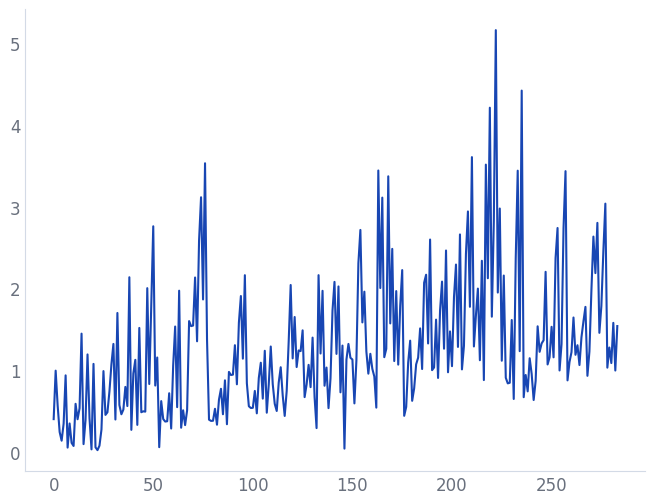

In [35]:
n = e3nn.norm(x)[0].array
plt.plot(n / 0.885)

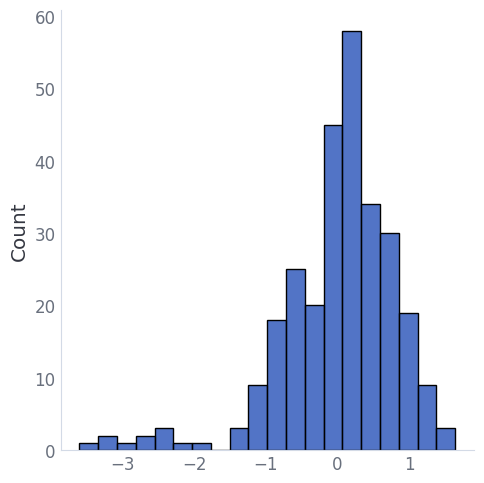

In [36]:
sns.displot(jnp.log(n / 0.885))

In [21]:
from eins import EinsOp, Reductions as R
from cdv.utils import debug_stat, debug_structure
nd = 8
index = slice(-1, 1, nd * 1j)

xyz = jnp.mgrid[index, index, index].reshape(3, -1).T

# https://www.wikiwand.com/en/List_of_common_coordinate_transformations#To_spherical_coordinates

def to_spherical(vecs):
    """vecs: [..., 3] -> (rho, azimuth, polar)"""    
    xx = vecs[..., 0]
    yy = vecs[..., 1]
    zz = vecs[..., 2]
    rho = R.l2_norm(vecs, axis=-1)
    azimuth = jnp.atan2(yy, xx) % (2 * jnp.pi)
    polar = jnp.atan2(jnp.hypot(xx, yy), zz)
    return rho, azimuth, polar

rho, azimuth, polar = to_spherical(xyz)
debug_stat(azimuth=azimuth / jnp.pi, polar=polar / jnp.pi, rho=rho);

azimuth
└──     (  0.0452    0.455    0.955     1.45     1.95)        1 ±    0.573

polar
└──     (  0.0635    0.304    0.468    0.685    0.937)      0.5 ±    0.211

rho
└──     (   0.247    0.845      1.1      1.3     1.73)     1.09 ±     0.31

In [24]:
from jax.scipy import special
from functools import partial

def _Y(m, l, vecs):
    rho, azimuth, polar = to_spherical(vecs)
    return special.sph_harm(jnp.atleast_1d(m), jnp.atleast_1d(l), azimuth, polar)

_Y(2, 2, xyz)

Array([-8.69802577e-08+0.25751615j, -8.69802577e-08+0.25751615j,
       -8.69802577e-08+0.25751615j, -8.69802577e-08+0.25751615j,
       -8.69802577e-08+0.25751615j, -8.69802577e-08+0.25751615j,
       -8.69802577e-08+0.25751615j, -8.69802577e-08+0.25751615j,
        8.35186988e-02+0.24359637j,  8.35186988e-02+0.24359637j,
        8.35186988e-02+0.24359637j,  8.35186988e-02+0.24359637j,
        8.35186988e-02+0.24359637j,  8.35186988e-02+0.24359637j,
        8.35186988e-02+0.24359637j,  8.35186988e-02+0.24359637j,
        1.77597329e-01+0.18647721j,  1.77597329e-01+0.18647721j,
        1.77597329e-01+0.18647721j,  1.77597329e-01+0.18647721j,
        1.77597329e-01+0.18647721j,  1.77597329e-01+0.18647721j,
        1.77597329e-01+0.18647721j,  1.77597329e-01+0.18647721j,
        2.47215495e-01+0.07210452j,  2.47215495e-01+0.07210452j,
        2.47215495e-01+0.07210452j,  2.47215495e-01+0.07210452j,
        2.47215495e-01+0.07210452j,  2.47215495e-01+0.07210452j,
        2.47215495e-01+0.

In [5]:
def generate_tuples_with_fixed_sum(length: int, sum: int):
    """Generates all non-negative integer tuples of a certain length with the specified sum."""
    if length == 1:
        yield (sum,)
        return

    if sum == 0:
        yield tuple(0 for _ in range(length))
        return

    for first in range(sum, -1, -1):
        for subtuple in generate_tuples_with_fixed_sum(length - 1, sum - first):
            yield (first,) + subtuple

from itertools import combinations

def gen_partitions(length: int, sum: int):
    for splits in combinations(range(sum + length - 1), r=length - 1):
        yield tuple(np.diff(splits, prepend=-1, append=sum + length - 1) - 1)

In [10]:
len(list(generate_tuples_with_fixed_sum(4, 0)))

1

In [11]:
s, l = 0, 4
set(generate_tuples_with_fixed_sum(s, l)) == set(gen_partitions(s, l))

: 

In [39]:
import math

math.comb(16, 4)

1820

In [2]:
from itertools import combinations

s = 0
l = 4

for splits in list(combinations(range(s + l - 1), l - 1)):
    print(np.diff(splits, prepend=-1, append=s + l - 1) - 1)

[0 0 0 0]
